In [1]:
import mcmc_functions as func
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import camb
import healpy as hp

In [2]:
fiducial_values = {'H0':67.4/1000, 
                   'ombh2': 0.0224, 
                   'omch2': 0.120, 
                   'mnu': 0.06, 
                   'tau': 0.054,
                   'As': 2.1e-9, 
                   'ns': 0.965}
observed_values = {'H0':67.6/1000, 
                   'ombh2': 0.0220, 
                   'omch2': 0.122, 
                   'mnu': 0.061, 
                   'tau': 0.050,
                   'As': 2.05e-9, 
                   'ns': 0.964}

errors_values = {'H0':1.0/1000, 
                 'ombh2': 0.00027, 
                 'omch2': 0.0025, 
                  'mnu': 0.014, 
                  'tau': 0.015,
                  'As': 1e-10, 
                  'ns': 0.003}


100%|██████████| 7/7 [00:24<00:00,  3.51s/it]
/apps/jupyterhub/2019-04-29/miniconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


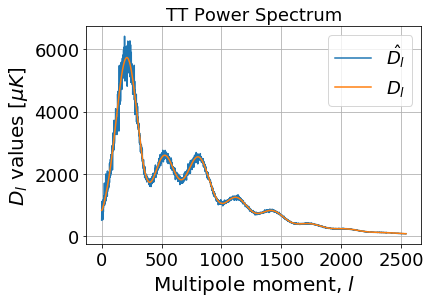

In [3]:
def generate_fiducial_dataset(params_dic, plot = False):
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=params_dic['H0']*1000, ombh2=params_dic['ombh2'], 
                       omch2=params_dic['omch2'], mnu=params_dic['mnu'], 
                       tau=params_dic['tau'])
    pars.InitPower.set_params(As=params_dic['As'], ns=params_dic['ns'], r=0)
    pars.set_for_lmax(2500, lens_potential_accuracy=0);
    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
    dl =powers['total'][:, 0]
    nside = 1024  
    cmb_map = hp.sphtfunc.synfast(dl, nside=nside)
    dl_hat = hp.sphtfunc.anafast(cmb_map)
    if len(dl) != len(dl_hat):
        min = np.min([len(dl), len(dl_hat)])
        dl = dl[:min]
        dl_hat = dl_hat[:min]
    ls = np.arange(len(dl))
    ls = ls[10:]
    dl = dl[10:]
    dl_hat = dl_hat [10:]
    if plot == True:
        plt.plot(dl_hat, label = r'$\hat{D_l}$')
        plt.plot(dl, label = r'$D_l$')
        plt.legend()
        plt.xlabel(r'Multipole moment, $l$')
        plt.ylabel(r'$D_l$ values [$\mu K$]')
        plt.title('TT Power Spectrum')
        plt.grid()
    return ls[30:2500], dl[30:2500], dl_hat[30:2500], min

fiducial_dataset_ls, fiducial_dataset_dl, fiducial_dataset_dl_hats, max_index = generate_fiducial_dataset(fiducial_values, plot = True)

five_point_derivative = func.five_point_derivative(fiducial_values, 
                                                errors_values)


In [4]:
import emcee

import emcee
import numpy as np


observed_values = {'H0':67.6/1000, 
                   'ombh2': 0.0220, 
                   'omch2': 0.122, 
                   'mnu': 0.061, 
                   'tau': 0.050,
                   'As': 2.05e-9, 
                   'ns': 0.964}

def estimate(theta):
    H0, ombh2 = theta
    observed_values['H0'] = H0
    observed_values['ombh2'] = ombh2
    
    observed_spectrum_cls, observed_spectrum_cl_hats = func.generate_cmb_power_spectrum(observed_values, cl_hats = True)
    cov_matrix = func.calc_cov_theory(observed_spectrum_cls)
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    estimates = func.MOPED(observed_spectrum_cl_hats,fiducial_dataset_dl,
                           inv_cov_matrix,five_point_derivative,
                           fiducial_values)
    
    return estimates


# Define the prior distribution
def log_prior(theta):
    H0, ombh2 = theta
    print(theta)
    if 0.06 < H0 < 0.073 and 0.01 < ombh2 < 0.04:
        return 0.0
    return -np.inf

# Combine into the full log-probability function
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + estimate(theta)

# Example values for fiducial_dls and ls_range
fiducial_dls = fiducial_dataset_dl
ls_range = np.arange(10, max_index)

# Initialize the walkers
nwalkers, ndim = 20, 2
p0 = [0.066, 0.025] + 1e-5 * np.random.randn(nwalkers, ndim)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)



In [5]:
sampler.run_mcmc(p0, 500, progress=True)

# Get the chain of sampled parameters
samples = sampler.get_chain(flat=True)

[0.06600831 0.02501876]
0.0 [[ 2.72136398e+05]
 [ 1.97643525e+04]
 [-9.87607954e+04]
 [-2.33305147e+07]
 [-1.38531807e+06]
 [-5.91647664e-03]
 [ 4.36156869e+05]]
[0.06601153 0.02498764]
0.0 [[ 2.72102224e+05]
 [ 1.97644133e+04]
 [-9.87526928e+04]
 [-2.33271618e+07]
 [-1.38505608e+06]
 [-5.91542734e-03]
 [ 4.36175949e+05]]
[0.065998   0.02501659]
0.0 [[ 2.72126726e+05]
 [ 1.97642099e+04]
 [-9.87598543e+04]
 [-2.33295264e+07]
 [-1.38519293e+06]
 [-5.91595100e-03]
 [ 4.36153879e+05]]
[0.0660019  0.02500201]
0.0 [[ 2.72112267e+05]
 [ 1.97642719e+04]
 [-9.87561423e+04]
 [-2.33281158e+07]
 [-1.38509311e+06]
 [-5.91555656e-03]
 [ 4.36163789e+05]]
[0.06599861 0.02499502]
0.0 [[ 2.72101804e+05]
 [ 1.97642320e+04]
 [-9.87541966e+04]
 [-2.33270732e+07]
 [-1.38499315e+06]
 [-5.91514689e-03]
 [ 4.36166411e+05]]
[0.06598329 0.02498892]
0.0 [[ 2.72083828e+05]
 [ 1.97640282e+04]
 [-9.87520493e+04]
 [-2.33252466e+07]
 [-1.38477663e+06]
 [-5.91424224e-03]
 [ 4.36163519e+05]]
[0.06598431 0.02500176]
0.0 

  0%|          | 0/1 [00:00<?, ?it/s]

[0.06601467 0.02502327]
0.0 [[ 2.72146271e+05]
 [ 1.97644343e+04]
 [-9.87622027e+04]
 [-2.33315117e+07]
 [-1.38542815e+06]
 [-5.91693370e-03]
 [ 4.36156949e+05]]
[0.06601331 0.02498681]
0.0 [[ 2.72102497e+05]
 [ 1.97644382e+04]
 [-9.87525310e+04]
 [-2.33271954e+07]
 [-1.38506653e+06]
 [-5.91547315e-03]
 [ 4.36177154e+05]]
[0.06600353 0.02501525]
0.0 [[ 2.72129046e+05]
 [ 1.97642859e+04]
 [-9.87596901e+04]
 [-2.33297753e+07]
 [-1.38523727e+06]
 [-5.91614120e-03]
 [ 4.36156925e+05]]
[0.06600889 0.02500212]
0.0 [[ 2.72117325e+05]
 [ 1.97643670e+04]
 [-9.87564119e+04]
 [-2.33286398e+07]
 [-1.38516644e+06]
 [-5.91586668e-03]
 [ 4.36166622e+05]]
[0.06599645 0.02499447]
0.0 [[ 2.72099648e+05]
 [ 1.97642032e+04]
 [-9.87539736e+04]
 [-2.33268532e+07]
 [-1.38496579e+06]
 [-5.91503210e-03]
 [ 4.36165821e+05]]
[0.06600852 0.02498337]
0.0 [[ 2.72095078e+05]
 [ 1.97643760e+04]
 [-9.87514564e+04]
 [-2.33264470e+07]
 [-1.38498428e+06]
 [-5.91513163e-03]
 [ 4.36177115e+05]]
[0.06600945 0.02500806]
0.0 

100%|██████████| 1/1 [03:37<00:00, 217.33s/it]


In [ ]:
import pickle

with open('outputs/moped1.pkl', 'wb') as f:
    pickle.dump(samples, f)


In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(["H0", "ombh2"][i]) 
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("Step number")
plt.show()

In [ ]:
import corner

fig = corner.corner(samples, smooth = 4.0, labels=["H0", "ombh2"],
                    truths=[0.70, 0.0022])  
plt.show()
print(samples.shape[0])

In [6]:
print('hi')

hi
